In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='AppleGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [9]:
train_data = pd.read_csv('merge_train_final.csv')
test_data = pd.read_csv('merge_test_final.csv')

In [10]:
remove_feature = ['Unnamed: 0', '도로명', '도로명주소', '시군구']
remove_test_feature = ['Unnamed: 0', '도로명', '도로명주소', '시군구']
train = train_data.drop(columns = remove_feature)
test = test_data.drop(columns = remove_test_feature)


In [11]:
train.columns

Index(['복도유형', '난방방식', '전용면적', '계약일', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'mean_높이', 'sum_건축면적',
       'mean_건축면적', '부속건축물수', 'target', '구', '동'],
      dtype='object')

In [12]:
test.shape

(9272, 20)

In [19]:
import datetime
#전처리 방식
def preprocessing(dataset):
    dataset['부속건축물수'] = dataset['부속건축물수'].fillna(0)
    dataset['아파트명'] = dataset['아파트명'].fillna('missing')
    dataset = dataset.interpolate(method = 'linear', axis = 0)
    return dataset

#파일 제출
def submission(preds):
    preds_df = pd.DataFrame(preds.astype(int), columns=["target"])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") # 현재 시간을 YYYYMMDD_HHMMSS 형식으로
    preds_df.to_csv(f'output_{current_time}.csv', index=False)    

In [16]:
df_train = preprocessing(train)
df_test = preprocessing(test)




In [22]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)


연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'x', 'y', '계약년월', 'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'mean_높이', 'sum_건축면적', 'mean_건축면적', '부속건축물수', 'target']
범주형 변수: ['복도유형', '난방방식', '아파트명', '구', '동']


In [23]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
        if label not in lbl.classes_: # unseen label 데이터인 경우
            lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


In [24]:
df_train.head(5).transpose()

,0,1,2,3,4
복도유형,0.000000,0.000000,0.000000,0.000000,0.000000
난방방식,0.000000,0.000000,0.000000,0.000000,0.000000
전용면적,79.970000,79.970000,54.980000,79.970000,79.970000
계약일,8.000000,22.000000,28.000000,3.000000,8.000000
층,3.000000,4.000000,5.000000,4.000000,2.000000
건축년도,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000
x,127.057210,127.057210,127.057210,127.057210,127.057210
y,37.476763,37.476763,37.476763,37.476763,37.476763
아파트명,328.000000,328.000000,328.000000,328.000000,328.000000
계약년월,201712.000000,201712.000000,201712.000000,201801.000000,201801.000000


In [25]:
y = df_train['target']
X = df_train.drop(['target'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 42)


In [30]:
X_train.shape

(895057, 20)

In [26]:
model1 = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model1.fit(X_train, y_train)
pred_1 = model1.predict(X_valid)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_valid, pred_1))}')

RMSE test: 7033.167517642885


In [27]:
pred = model1.predict(df_test)

In [28]:
submission(pred)

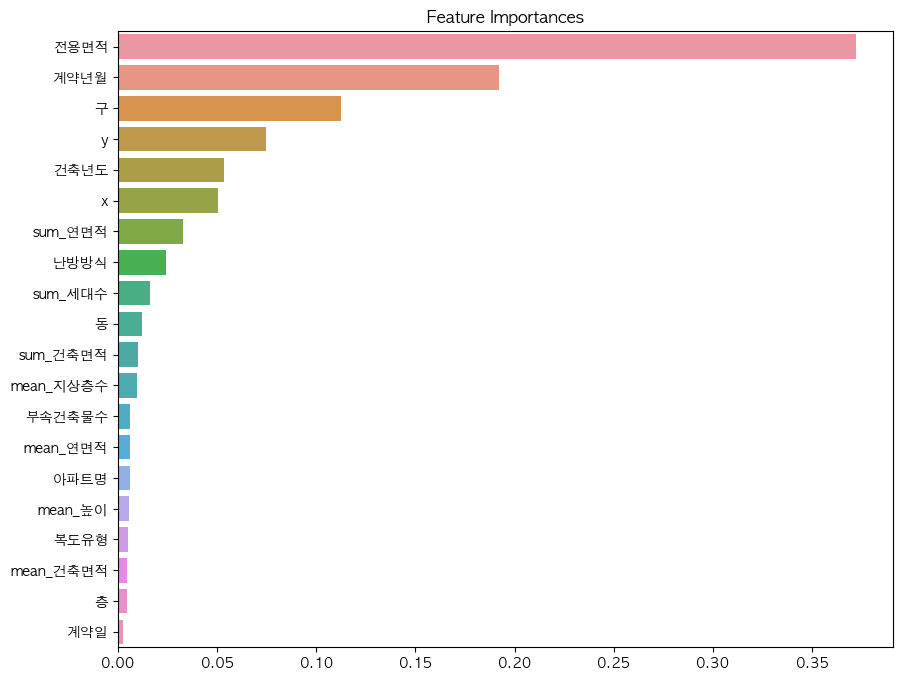

In [29]:
import pandas as pd
importances = pd.Series(model1.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_valid['target'] = y_valid
X_valid['pred'] = pred_1

# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_valid['target'], X_valid['pred'])
X_valid['error'] = squared_errors

# Error가 큰 순서대로 sorting 해 보겠습니다.
X_valid_sort = X_valid.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [31]:

df_train_cat = preprocessing(train)
df_test_cat = preprocessing(train)

y_cat = df_train_cat['target']
X_cat = df_train_cat.drop(['target'], axis = 1)
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state = 42)



In [37]:
X_train_cat.columns

Index(['복도유형', '난방방식', '전용면적', '계약일', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'mean_높이', 'sum_건축면적',
       'mean_건축면적', '부속건축물수', '구', '동'],
      dtype='object')

In [39]:
from catboost import CatBoostRegressor


def optimizer_cat(trial):
    cat_features = [0,1,8,18,19]
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 5000),
        'od_wait':trial.suggest_int('od_wait', 500, 2000),
        'loss_function':'RMSE',
        'task_type':"GPU",
        'eval_metric':'RMSE',
        'bootstrap_type': 'Bernoulli',
        'learning_rate' : trial.suggest_uniform('learning_rate',0.02,1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1,15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15)
    }
    
    model_cat = CatBoostRegressor(**params, cat_features= cat_features)
    model_cat.fit(X_train_cat, y_train_cat)
    
    preds = model_cat.predict(X_valid_cat)
    rmse = mean_squared_error(y_valid_cat, preds, squared = False)
    return rmse

In [40]:
import optuna
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(optimizer_cat, n_trials=100)


# 최적의 하이퍼파라미터 출력
print('Best trial:', study_cat.best_trial.params)

[I 2024-01-18 18:15:02,828] A new study created in memory with name: no-name-e6e71fcb-aa4e-4bbc-b3ec-496ccb9e51ba
[W 2024-01-18 18:15:03,992] Trial 0 failed with parameters: {'iterations': 1092, 'od_wait': 590, 'learning_rate': 0.3854139016348413, 'reg_lambda': 3.5662668379838816, 'subsample': 0.5551649123714035, 'random_strength': 29.16631587025175, 'depth': 5, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 13} because of the following error: CatBoostError('/Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found').
Traceback (most recent call last):
  File "/Users/ijunhyeong/dev/apart-project/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/37/sywtf7112qqfqmjzz63jw0cm0000gn/T/ipykernel_34753/193810051.py", line 23, in optimizer_cat
    model_cat.f

CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/train_lib/trainer_env.cpp:9: Environment for task type [GPU] not found

In [ ]:
best_trial = study3.best_trial

best_params3 = best_trial.params
best_model3 = lgb.LGBMRegressor(**best_params3)
best_model3.fit(X_valid, y_valid)
answer3 = best_model3.predict(X_test)
